### TAHMO Data

In [ ]:
!pip install filter_stations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 19.4 MB/s eta 0:00:00


In [ ]:
# upload config file
from google.colab import files
uploaded = files.upload()

Saving config.json to config.json


In [ ]:
from filter_stations import retreive_data
import json
import os

config_path = '/content/config.json'
with open(config_path) as f:
    config = json.load(f)


# authenticate the api
api_key = config['apiKey']
api_secret = config['apiSecret']
maps_key = config['map_api_key']

ret = retreive_data(api_key, api_secret, maps_key)

# Sample stations list
stations = [
    'TA00026',
    'TA00027',
    'TA00028',
    'TA00029',
    'TA00056',
    'TA00073',
    'TA00074',
    'TA00078',
    'TA00166',
    'TA00172',
    'TA00174',
    'TA00190',
    'TA00196',
    'TA00247',
    'TA00258',
    'TA00283', # Dedan Kimathi station
    'TA00377',
    'TA00378',
    'TA00379',
    'TA00386',
    'TA00414',
    'TA00416',
    'TA00444',
    'TA00719'
]

if __name__ == '__main__':
    variables = ['pr']
    start_date = '2023-01-01'
    end_date = '2023-12-31'
    dataset = 'controlled'
    csv_file_name = f'pr-2023-2024'

  # Aggregate presipitation data for 1 day the current default is summming up
    pr_df = ret.multiple_measurements(
        startDate=start_date, endDate=end_date,
        dataset=dataset, stations_list=stations,
        csv_file=csv_file_name, aggregate='1D',
        variables=variables
    )

    # Getting temperature data for the same duration 5min interval
    variables = ['te']
    csv_file_name = f'te-2023-2024'
    te_df = ret.multiple_measurements(
        startDate=start_date, endDate=end_date,
        dataset=dataset, stations_list=stations,
        csv_file=csv_file_name, aggregate='5min',
        variables=variables
    )

    # Aggregate the te_df per day by mean
    print('Aggregating temperature data ---')
    te_df_agg = ret.aggregate_variables(te_df, freq='1D', method='mean')

    # Get the stations metadata
    print('Getting stations metadata ---')
    stations_metadata = ret.get_stations_info(multipleStations=stations)

    # Get the stations info for kenya
    print('Getting stations metadata for kenya ---')
    stations_ke = ret.get_stations_info(countrycode='KE')

    # Get the available variables
    print('Getting available variables ---')
    we_vars = ret.get_variables()



Retrieving data for stations:   0%|          | 0/24 [00:00<?, ?it/s]

Retrieving data for stations:   0%|          | 0/24 [00:00<?, ?it/s]

Aggregating temperature data ---
Getting stations metadata ---
Getting stations metadata for kenya ---
Getting available variables ---


In [ ]:
stations_metadata

,code,status,installationdate,elevationground,sensorinstallations,dataloggerinstallations,creatorid,created,updaterid,updated,...,location.countrycode,location.zipcode,location.latitude,location.longitude,location.elevationmsl,location.note,location.creatorid,location.created,location.updaterid,location.updated
24,TA00026,1,2015-08-28T00:00:00Z,3.0,None,None,2,2018-12-11T08:15:40.289703Z,2,2018-12-11T08:15:40.289703Z,...,KE,,-0.287122,36.169981,1939.9,{},2,2018-10-26T13:27:43.87694Z,2,2022-07-26T07:25:44.100506Z
25,TA00027,0,2015-08-31T00:00:00Z,2.0,None,None,2,2018-12-11T08:33:13.846345Z,37,2019-03-22T08:43:27.216443Z,...,KE,,0.063061,37.656303,1607.0,{},2,2018-10-26T13:30:50.270697Z,2,2018-10-26T13:30:50.270697Z
26,TA00028,1,2015-08-31T00:00:00Z,9.0,None,None,2,2018-12-11T08:35:17.888233Z,2,2018-12-11T08:35:17.888233Z,...,KE,,0.055219,37.136747,2003.6,{},2,2018-10-26T13:32:16.15537Z,37,2022-06-30T11:11:50.27135Z
27,TA00029,1,2015-09-02T00:00:00Z,2.0,None,None,2,2018-12-11T08:36:19.30342Z,2,2018-12-11T08:36:19.30342Z,...,KE,,-0.500776,36.587511,2545.8,{},2,2018-10-26T13:33:31.451613Z,37,2022-02-28T12:25:09.578242Z
52,TA00056,1,2015-10-03T00:00:00Z,2.0,None,None,2,2018-12-11T09:20:32.851033Z,2,2018-12-11T09:20:32.851033Z,...,KE,,-0.721656,37.145585,1376.0,{},2,2018-10-29T09:11:21.843353Z,2,2018-10-29T09:11:21.843353Z
67,TA00073,1,2015-11-19T00:00:00Z,2.0,None,None,2,2018-12-11T09:37:47.276024Z,2,2018-12-11T09:37:47.276024Z,...,KE,,-0.071723,36.933835,1853.5,{},2,2018-10-29T10:24:02.405958Z,37,2022-02-28T12:46:24.127554Z
68,TA00074,1,2015-11-19T00:00:00Z,2.0,None,None,2,2018-12-11T09:38:25.742397Z,2,2018-12-11T09:38:25.742397Z,...,KE,,-0.566080,37.074412,1726.8,{},2,2018-10-29T10:35:28.49617Z,2,2022-07-26T07:38:42.100985Z
72,TA00078,1,2016-01-11T00:00:00Z,2.5,None,None,2,2018-12-11T09:41:34.473889Z,2,2018-12-11T09:41:34.473889Z,...,KE,,-0.200178,36.376936,2427.2,{},2,2018-10-29T10:49:20.072927Z,2,2022-07-26T07:39:36.348657Z
150,TA00166,1,2017-05-11T00:00:00Z,2.0,None,None,2,2018-12-12T08:29:28.10697Z,2,2018-12-12T08:29:28.10697Z,...,KE,,-0.319508,37.659139,1404.0,{},2,2018-11-10T08:47:37.949135Z,2,2018-11-10T08:47:37.949135Z
156,TA00172,1,2017-05-19T00:00:00Z,2.0,None,None,2,2018-12-12T08:55:49.278399Z,2,2018-12-12T08:55:49.278399Z,...,KE,,0.353931,37.587740,1110.0,{},2,2018-11-10T09:09:21.659661Z,2,2018-11-10T09:09:21.659661Z


### CHIRPS

In [ ]:
import ee
ee.Authenticate()

# Initialize Google Earth Engine
ee.Initialize(project='ee-kaburiaaustin1')


True

In [ ]:
# Define a region of interest (bounding box)
roi = ee.Geometry.Rectangle([36.0, -1.0, 37.0, 1.0])  # Coordinates for an example region in Kenya

# Load CHIRPS dataset
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate('2023-01-01', '2023-12-31') \
            .filterBounds(roi)

# Calculate total rainfall for the year
total_rainfall = chirps.sum().clip(roi)

# Method to extract rainfall data at a specific point
def extract_rainfall_at_point(lat, lon):
    point = ee.Geometry.Point(lon, lat)  # Define the point from latitude and longitude
    rainfall_value = total_rainfall.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=5000
    )
    return rainfall_value

# Example: Extract rainfall data for a specific point (latitude, longitude)
lat, lon = -0.5, 36.5  # Example coordinates
rainfall_data = extract_rainfall_at_point(lat, lon)

# Print the extracted rainfall data
rainfall_data_result = rainfall_data.getInfo()  # Convert to a Python dictionary
print(f"Rainfall data at point ({lat}, {lon}): {rainfall_data_result}")


Rainfall data at point (-0.5, 36.5): {'precipitation': 897.6481462195516}


In [ ]:
import ee
import pandas as pd

# Initialize Google Earth Engine
ee.Initialize(project='ee-kaburiaaustin1')

# Define a region of interest (bounding box)
roi = ee.Geometry.Rectangle([36.0, -1.0, 37.0, 1.0])  # Coordinates for an example region in Kenya

# Load CHIRPS dataset
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate('2023-01-01', '2023-12-31') \
            .filterBounds(roi)

# Method to extract rainfall data at a specific point for each date in the time range
def extract_rainfall_series(lat, lon):
    point = ee.Geometry.Point(lon, lat)  # Define the point from latitude and longitude

    # Map function to extract rainfall for each day and create a time series
    def extract_rainfall(image):
        # Get the date for the image (e.g., "YYYY-MM-DD")
        date = image.get('system:time_start')
        # Extract the rainfall value at the point for that date
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=5000
        ).get('precipitation')  # 'precipitation' is the band name for CHIRPS

        return ee.Feature(None, {
            'date': ee.Date(date).format('YYYY-MM-dd'),
            'rainfall': value
        })

    # Apply the function to each image in the collection
    rainfall_series = chirps.map(extract_rainfall)

    # Convert the FeatureCollection to a list of features
    features = rainfall_series.getInfo()['features']

    # Convert to pandas DataFrame
    data = [{'Date': f['properties']['date'], 'rainfall': f['properties']['rainfall']} for f in features]
    df = pd.DataFrame(data)

    # Ensure 'date' is a datetime object
    df['Date'] = pd.to_datetime(df['Date'])

    return df

# Example: Extract rainfall data for a specific point (latitude, longitude)
lat, lon = -0.287122, 36.169981  # Example coordinates
rainfall_df = extract_rainfall_series(lat, lon)

# Print the DataFrame containing the rainfall time series
rainfall_df


,Date,rainfall
0,2023-01-01,0.0
1,2023-01-02,0.0
2,2023-01-03,0.0
3,2023-01-04,0.0
4,2023-01-05,0.0
...,...,...
359,2023-12-26,0.0
360,2023-12-27,0.0
361,2023-12-28,0.0
362,2023-12-29,0.0


<Axes: xlabel='Date'>

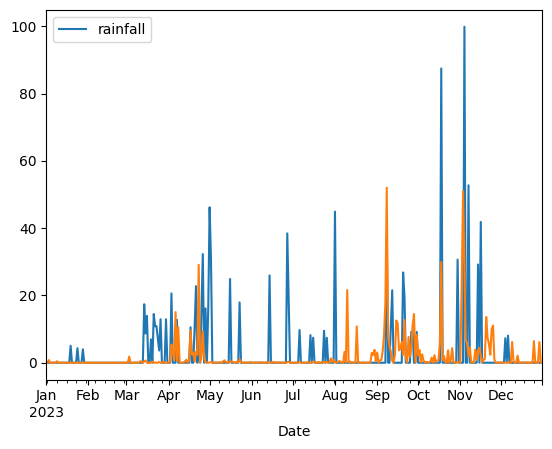

In [ ]:
rainfall_df.plot(x='Date', y='rainfall')
pr_df['TA00026'].plot()


### ERA5

In [ ]:
import ee
import pandas as pd

# Initialize Google Earth Engine
ee.Initialize(project='ee-kaburiaaustin1')

# Define a region of interest (bounding box)
roi = ee.Geometry.Rectangle([36.1, -0.3, 36.2, -0.2])  # Coordinates for an example region in Kenya

# Load ERA5 hourly dataset (temperature example)
era5_hourly = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                .filterDate('2023-01-01', '2023-12-31') \
                .filterBounds(roi) \
                .select('total_precipitation')  # Select the 'temperature_2m' variable for hourly temperature

# Method to extract ERA5 hourly data at a specific point for each time step
def extract_era5_hourly_series(lat, lon):
    point = ee.Geometry.Point(lon, lat)  # Define the point from latitude and longitude

    # Map function to extract temperature for each hour and create a time series
    def extract_temperature(image):
        # Get the date and time for the image (e.g., "YYYY-MM-DD HH:MM:SS")
        date = image.get('system:time_start')
        # Extract the temperature value at the point for that date
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=5000
        ).get('total_precipitation')  # 'temperature_2m' is the band name for ERA5 temperature

        return ee.Feature(None, {
            'datetime': ee.Date(date).format('YYYY-MM-dd HH:mm:ss'),
            'rainfall': value
        })

    # Apply the function to each image in the collection (hourly data)
    temperature_series = era5_hourly.map(extract_temperature)

    # Convert the FeatureCollection to a list of features
    features = temperature_series.getInfo()['features']

    # Convert to pandas DataFrame
    data = [{'Date': f['properties']['datetime'], 'rainfall': f['properties']['rainfall']} for f in features]
    df = pd.DataFrame(data)

    # Ensure 'datetime' is a datetime object
    df['Date'] = pd.to_datetime(df['Date'])

    return df

# Example: Extract temperature data for a specific point (latitude, longitude)
lat, lon = -0.287122, 36.169981  # Example coordinates
era5_pr_df = extract_era5_hourly_series(lat, lon)

# Print the DataFrame containing the hourly temperature time series
era5_pr_df


EEException: User memory limit exceeded.

<Axes: xlabel='datetime'>

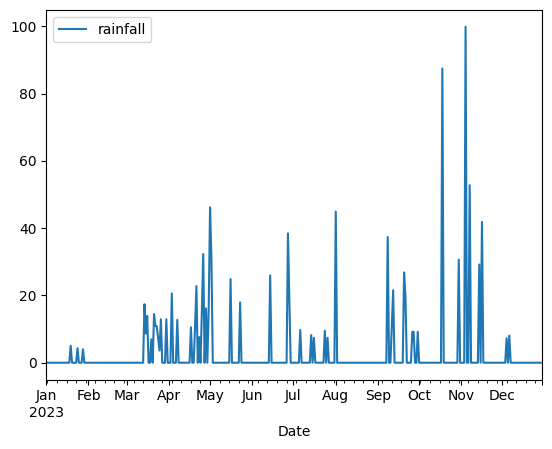

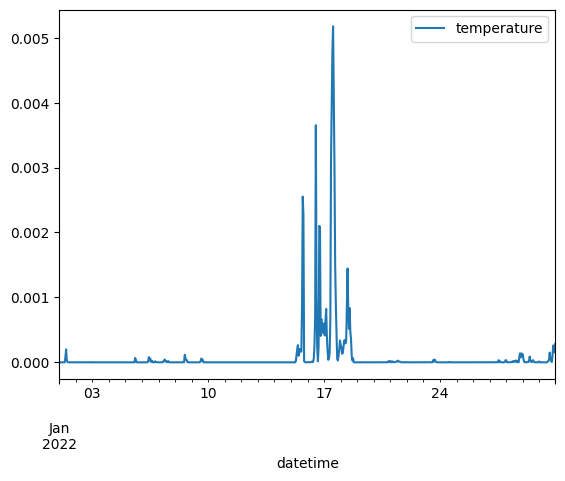

In [ ]:
rainfall_df.plot(x='Date', y='rainfall')
temperature_df.plot(x='datetime', y='temperature')


In [ ]:
# prompt: from google.colab import drive get the drive here

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: import the file GeoTIFF from drive

import ee
import geemap

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-kaburiaaustin1')

# Define the file path to your GeoTIFF on Google Drive.
# Replace with the actual path to your GeoTIFF file.
geotiff_file_path = '/content/drive/MyDrive/CHIRPS_total_rainfall_2022.tif'

try:
  # Open the GeoTIFF file using geemap.
  image = geemap.geotiff_to_ee(geotiff_file_path)

  # Now you can work with the image object in Earth Engine.
  # Example: print some information about the image.
  print(image.getInfo())


except Exception as e:
  print(f"An error occurred: {e}")
  print("Please make sure the file path is correct and the GeoTIFF file exists.")

An error occurred: module 'geemap' has no attribute 'geotiff_to_ee'
Please make sure the file path is correct and the GeoTIFF file exists.


In [ ]:
task

<Task H3OLDF5DK73KMKOL5D7W7NTE Type.EXPORT_IMAGE: CHIRPS_total_rainfall_2022 (State.UNSUBMITTED)>

### CBAM

In [ ]:
import requests

# Replace with your API key
API_KEY = 'ah3J0edhmrvUGbozePmKzwv18yKvQgA9'

# Example API endpoint for getting weather data
url = "https://api.tomorrow.io/v4/weather/forecast"

# Parameters for the request (adjust for CBAM-specific data)
params = {
    'location': '37.7749,-122.4194',  # Example coordinates (latitude, longitude)
    'units': 'metric',
    'timesteps': '1h',
    'apikey': API_KEY,
}

# Sending the GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    cbam_data = response.json()
    print(cbam_data)  # Process your CBAM data here
else:
    print(f"Error: {response.status_code}")


{'timelines': {'hourly': [{'time': '2025-01-22T05:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 2, 'dewPoint': 2.63, 'evapotranspiration': 0.104, 'freezingRainIntensity': 0, 'hailProbability': 52.7, 'hailSize': 4.97, 'humidity': 67, 'iceAccumulation': 0, 'iceAccumulationLwe': 0, 'precipitationProbability': 0, 'pressureSurfaceLevel': 1025.9, 'rainAccumulation': 0, 'rainAccumulationLwe': 0, 'rainIntensity': 0, 'sleetAccumulation': 0, 'sleetAccumulationLwe': 0, 'sleetIntensity': 0, 'snowAccumulation': 0, 'snowAccumulationLwe': 0, 'snowDepth': 0, 'snowIntensity': 0, 'temperature': 8.31, 'temperatureApparent': 8.31, 'uvHealthConcern': 0, 'uvIndex': 0, 'visibility': 16, 'weatherCode': 1000, 'windDirection': 313, 'windGust': 3.5, 'windSpeed': 2.88}}, {'time': '2025-01-22T06:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 1.74, 'dewPoint': 3.06, 'evapotranspiration': 0.085, 'freezingRainIntensity': 0, 'hailProbability': 7.9, 'hailSize': 6

In [ ]:
import pandas as pd

In [ ]:
cbam_data.keys()

dict_keys(['timelines', 'location'])

In [ ]:
response.json()['location']

{'lat': 37.7749, 'lon': -122.4194}

In [ ]:
pd.json_normalize(response.json()['timelines']['hourly'])

,time,values.cloudBase,values.cloudCeiling,values.cloudCover,values.dewPoint,values.evapotranspiration,values.freezingRainIntensity,values.hailProbability,values.hailSize,values.humidity,...,values.snowIntensity,values.temperature,values.temperatureApparent,values.uvHealthConcern,values.uvIndex,values.visibility,values.weatherCode,values.windDirection,values.windGust,values.windSpeed
0,2025-01-22T05:00:00Z,NaN,NaN,2.00,2.63,0.104,0,52.7,4.97,67,...,0,8.31,8.31,0.0,0.0,16.00,1000,313.00,3.50,2.88
1,2025-01-22T06:00:00Z,NaN,NaN,1.74,3.06,0.085,0,7.9,6.80,65,...,0,9.48,9.48,0.0,0.0,16.00,1000,334.79,3.88,2.74
2,2025-01-22T07:00:00Z,NaN,NaN,0.00,3.15,0.074,0,27.1,5.91,67,...,0,9.05,9.05,0.0,0.0,16.00,1000,338.06,4.26,2.95
3,2025-01-22T08:00:00Z,NaN,NaN,0.00,3.38,0.063,0,90.1,0.61,69,...,0,8.97,8.97,0.0,0.0,16.00,1000,9.25,4.22,2.99
4,2025-01-22T09:00:00Z,NaN,NaN,0.00,3.12,0.053,0,14.2,7.31,70,...,0,8.46,8.46,0.0,0.0,16.00,1000,22.10,3.90,2.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2025-01-27T00:00:00Z,NaN,NaN,0.00,-0.95,0.098,0,37.2,5.29,40,...,0,12.47,12.47,NaN,NaN,24.13,1000,149.98,4.70,3.06
116,2025-01-27T01:00:00Z,NaN,NaN,0.00,0.28,0.078,0,93.5,2.36,45,...,0,12.09,12.09,NaN,NaN,24.13,1000,149.98,4.37,3.16
117,2025-01-27T02:00:00Z,NaN,NaN,0.00,1.52,0.057,0,55.5,9.24,50,...,0,11.71,11.71,NaN,NaN,24.13,1000,301.03,4.04,3.27
118,2025-01-27T03:00:00Z,NaN,NaN,0.00,2.75,0.037,0,71.0,9.50,56,...,0,11.33,11.33,NaN,NaN,24.14,1000,301.03,3.72,3.37


In [ ]:
import requests

# Replace with your actual API key
API_KEY = 'ah3J0edhmrvUGbozePmKzwv18yKvQgA9'

# Example API endpoint for historical weather data
url = "https://api.tomorrow.io/v4/timelines"

# Parameters for historical data request
params = {
    'location': '37.7749,-122.4194',  # Latitude, Longitude for the desired location
    'fields': ['temperature', 'windSpeed', 'humidity'],  # Replace with required CBAM fields
    'units': 'metric',  # Metric units for temperature, speed, etc.
    'timesteps': '1h',  # Time step resolution
    'startTime': '2024-01-01T00:00:00Z',  # Start date (in ISO 8601 format)
    'endTime': '2025-01-22T23:59:59Z',  # End date
    'timezone': 'UTC',  # Specify timezone if needed
    'apikey': API_KEY,  # API key
}

# Sending the GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    cbam_data = response.json()
    print(cbam_data)  # Process or save your historical CBAM data
else:
    print(f"Error: {response.status_code} - {response.text}")


Error: 403 - {"code":403003,"type":"Forbidden Action","message":"The plan is restricted and cannot perform this action. Adjust action and try again: startTime cannot be more than 24 hours in the past."}


In [ ]:
!curl --request GET \
  --url 'https://api.tomorrow.io/v4/timelines?location=37.7749,-122.4194&fields=temperature,precipitation&units=metric&timesteps=1h&startTime=2023-01-01T00:00:00Z&endTime=2023-12-31T23:59:59Z' \
  --header 'apikey: ah3J0edhmrvUGbozePmKzwv18yKvQgA9'


{"code":403003,"type":"Forbidden Action","message":"The plan is restricted and cannot perform this action. Adjust action and try again: startTime cannot be more than 24 hours in the past."}

### TAMSAT

In [ ]:
!git clone https://github.com/TAMSAT/tamsat_download_extraction_api

Cloning into 'tamsat_download_extraction_api'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 18), reused 23 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 585.12 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ffeaa55b90226d7ea42bfb95545ac47835cc9fa631630f6319f25903dd304956
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!pip install numpy==1.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (numpy)


In [ ]:
import sys
sys.path.append('/content/tamsat_download_extraction_api')

from tamsat_download_extract_api import download, extract


In [ ]:
download({
 "timestep": 'daily',
 "resolution": 0.25,
 "start_date": '2023-01-01',
 "end_date": '2023-12-31',
 "version": 3.1,
 "localdata_dir": '/home/user/scripts/tamsat_api/data'
 })

/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Day.apply(lambda x: x in ["01", "02", "03", "04", "05"]), "Pentad"] = "1"
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DJF' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Month.ap

365 file(s) to download
 Downloaded file: rfe2023_01_01_0.25.v3.1.nc
 Downloaded file: rfe2023_01_02_0.25.v3.1.nc
 Downloaded file: rfe2023_01_03_0.25.v3.1.nc
 Downloaded file: rfe2023_01_04_0.25.v3.1.nc
 Downloaded file: rfe2023_01_05_0.25.v3.1.nc
 Downloaded file: rfe2023_01_06_0.25.v3.1.nc
 Downloaded file: rfe2023_01_07_0.25.v3.1.nc
 Downloaded file: rfe2023_01_08_0.25.v3.1.nc
 Downloaded file: rfe2023_01_09_0.25.v3.1.nc
 Downloaded file: rfe2023_01_10_0.25.v3.1.nc
 Downloaded file: rfe2023_01_11_0.25.v3.1.nc
 Downloaded file: rfe2023_01_12_0.25.v3.1.nc
 Downloaded file: rfe2023_01_13_0.25.v3.1.nc
 Downloaded file: rfe2023_01_14_0.25.v3.1.nc
 Downloaded file: rfe2023_01_15_0.25.v3.1.nc
 Downloaded file: rfe2023_01_16_0.25.v3.1.nc
 Downloaded file: rfe2023_01_17_0.25.v3.1.nc
 Downloaded file: rfe2023_01_18_0.25.v3.1.nc
 Downloaded file: rfe2023_01_19_0.25.v3.1.nc
 Downloaded file: rfe2023_01_20_0.25.v3.1.nc
 Downloaded file: rfe2023_01_21_0.25.v3.1.nc
 Downloaded file: rfe2023_01_22

In [ ]:
extract({
 "extract_type": 'point',
 "longitude": 36.169981,
 "latitude": -0.287122,
 "timestep": 'daily',
 "start_date": '2023-01-01',
 "end_date": '2023-12-31',
 "version": 3.1,
 "localdata_dir": '/home/user/scripts/tamsat_api/data'
 })

Extracting point TAMSAT rainfall estimates for longitude: 36.169981 and latitude: -0.287122


/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Day.apply(lambda x: x in ["01", "02", "03", "04", "05"]), "Pentad"] = "1"
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DJF' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Month.ap

Created file: /home/user/scripts/tamsat_api/data/extracted_data/point/TAMSATv3.1_daily_0.25_36.169981_-0.287122_2023-01-01_2023-12-31.csv


In [ ]:
import pandas as pd
tamsat_t26 = pd.read_csv('/home/user/scripts/tamsat_api/data/extracted_data/point/TAMSATv3.1_daily_0.25_36.169981_-0.287122_2023-01-01_2023-12-31.csv')
tamsat_t26.time = pd.to_datetime(tamsat_t26.time)
tamsat_t26.set_index('time', inplace=True)

In [ ]:
tamsat_t26

,rfe,rfe_filled,lon,lat
time,,,,
2023-01-01,0.0000,0.0000,36.125,-0.375
2023-01-02,0.0000,0.0000,36.125,-0.375
2023-01-03,0.0000,0.0000,36.125,-0.375
2023-01-04,0.0000,0.0000,36.125,-0.375
2023-01-05,0.0000,0.0000,36.125,-0.375
...,...,...,...,...
2023-12-27,0.0000,0.0000,36.125,-0.375
2023-12-28,0.0000,0.0000,36.125,-0.375
2023-12-29,4.2000,4.2000,36.125,-0.375


<Axes: xlabel='time'>

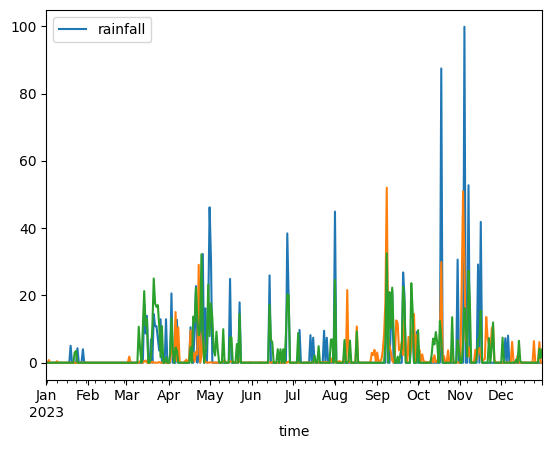

In [ ]:
rainfall_df.plot(x='Date', y='rainfall')
pr_df['TA00026'].plot()

tamsat_t26['rfe'].plot()

In [ ]:
cbam_data['timelines']['hourly']

[{'time': '2025-01-22T05:00:00Z',
  'values': {'cloudBase': None,
   'cloudCeiling': None,
   'cloudCover': 2,
   'dewPoint': 2.63,
   'evapotranspiration': 0.104,
   'freezingRainIntensity': 0,
   'hailProbability': 68.9,
   'hailSize': 2.64,
   'humidity': 67,
   'iceAccumulation': 0,
   'iceAccumulationLwe': 0,
   'precipitationProbability': 0,
   'pressureSurfaceLevel': 1025.9,
   'rainAccumulation': 0,
   'rainAccumulationLwe': 0,
   'rainIntensity': 0,
   'sleetAccumulation': 0,
   'sleetAccumulationLwe': 0,
   'sleetIntensity': 0,
   'snowAccumulation': 0,
   'snowAccumulationLwe': 0,
   'snowDepth': 0,
   'snowIntensity': 0,
   'temperature': 8.31,
   'temperatureApparent': 8.31,
   'uvHealthConcern': 0,
   'uvIndex': 0,
   'visibility': 16,
   'weatherCode': 1000,
   'windDirection': 313,
   'windGust': 3.5,
   'windSpeed': 2.88}},
 {'time': '2025-01-22T06:00:00Z',
  'values': {'cloudBase': None,
   'cloudCeiling': None,
   'cloudCover': 0.78,
   'dewPoint': 3.06,
   'evapotra